In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [3]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

In [4]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

In [5]:
#DQN
class LSTM_(torch.nn.Module):
    def __init__(self,n_features,seq_length, linear_output, memory_size):
        super(LSTM_, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.linear_outputs = linear_output
        self.batch_size = memory_size
        self.n_hidden = 512 #90
        
        self.lstm   = nn.LSTMCell(n_features, self.n_hidden)
        self.lstm_1 = nn.LSTMCell(self.n_hidden, self.n_hidden)

        self.fc = nn.Linear(self.n_hidden,self.linear_outputs) 
        
        
    def forward(self, x, future = 0):
        outputs = []
        n_batches = x.size(0)
        
        #set batches to 1 if batches == memory size
        if n_batches != 40:
            n_batches = 1
        
        #print('n_batches: ',n_batches)
        #first LSTM
        hidden_state   = torch.zeros(n_batches, self.n_hidden, dtype = torch.float32, device=device)
        #print('h1_size',hidden_state.shape)
        cell_state     = torch.zeros(n_batches, self.n_hidden, dtype = torch.float32, device=device)
        #print('c1_size',cell_state.shape)
        

        #second LSTM
        hidden_state_1 = torch.zeros(n_batches, self.n_hidden, dtype = torch.float32, device=device)
        #print('h2_size',hidden_state_1.shape)
        cell_state_1   = torch.zeros(n_batches, self.n_hidden, dtype = torch.float32, device=device)
        #print('c2_size',cell_state_1.shape)
        
        #print('sample_size: ',x.shape)
        #x = torch.transpose(x, 0, 1)
        x = x.squeeze()
        #x = torch.transpose(x, 0, 1)
        #print('sample_size_1: ',x.shape)
        #print('batch/memory input size: ', x.shape[0])
        if x.shape[0] != 40:
            #print('batch input mode')
            #print(x[0].shape)
            for i in range(self.batch_size):
                x_ = x[i]
                mean_outputs = []
                for input_t in torch.split(x_,1):
                    #print('input_t(batch mode): ',input_t.shape)
                    hidden_state, cell_state = self.lstm(input_t,(hidden_state,cell_state))
                    hidden_state_1, cell_state_1 = self.lstm_1(hidden_state,(hidden_state_1,cell_state_1))
                    output = self.fc(hidden_state_1)
                    mean_outputs.append(output)
                mean_outputs = torch.cat(mean_outputs)
                mean_outputs = mean_outputs.mean().to('cpu')
                #print('BO type: ',type(mean_outputs))
                outputs.append(mean_outputs)
            outputs = torch.stack(outputs)
            #print('out length: ',len(outputs))
            #print('out length: ',outputs.shape)
            
            print('batched outputs: ',outputs.shape, ' Expected: [256, 1]')
            return outputs
        else:
            for input_t in torch.split(x, 1):
                #print('input_t ',input_t.shape)
                hidden_state, cell_state = self.lstm(input_t,(hidden_state,cell_state))
                hidden_state_1, cell_state_1 = self.lstm_1(hidden_state,(hidden_state_1,cell_state_1))
                output = self.fc(hidden_state_1)
                outputs.append(output)
        
            for i in range(future):
                hidden_state, cell_state = self.lstm(output,(hidden_state,cell_state))
                hidden_state_1, cell_state_1 = self.lstm_1(hidden_state,(hidden_state_1,cell_state_1))
                output = self.fc(hidden_state_1)
                outputs.append(output)
        
            outputs = torch.cat(outputs)
            outputs = outputs.mean().to('cpu')
            print('outputs: ',outputs.shape, ' Expected: [1]')
            return outputs

In [6]:
class EnvManager():
    def __init__(self, device,environment):
        self.device = device
        self.env = gym.make(environment).unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
        
    def num_actions_available(self):
        return self.env.action_space
        
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action)
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
       
    def get_processed_screen(self):
        screen = em.render('rgb_array')
        rgb_weights = [0.2989, 0.5870, 0.1140]
        grayscale_image = np.dot(screen[...,:3], rgb_weights) 
        screen = grayscale_image.transpose((0, 1)) # PyTorch expects CHW
        #print(type(screen)) # numpy
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[0]
        screen_width  = screen.shape[1]
        #print('screen height(top/bottom): ',screen_height)
        #print('screen height(left/right): ',screen_width)
        # Strip off top and bottom
        top = int(screen_height * 0.2)
        #print('top: ',top)
        bottom = int(screen_height * 0.8)
        #print('bottom: ',bottom)
        
        
        #strip off left/right
        left  = int(screen_width * 0.2)
        #print('left: ',left)
        right = int(screen_width * 0.8)
        #print('right: ',right)
        
        screen = screen[top:bottom, left:right]
        return screen
    
    
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
environment = 'Pendulum-v0'
em = EnvManager(device,environment)
em.reset()
screen = em.render('rgb_array')




plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()
em.close()

Exception ignored in: <function Viewer.__del__ at 0x000001687E931828>
Traceback (most recent call last):
  File "c:\users\scowt\appdata\local\programs\python\python37\lib\site-packages\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "c:\users\scowt\appdata\local\programs\python\python37\lib\site-packages\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "c:\users\scowt\appdata\local\programs\python\python37\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "c:\users\scowt\appdata\local\programs\python\python37\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "c:\users\scowt\appdata\local\programs\python\python37\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: (<weakref at 0x000001687E5AC5E8; to 'Win32Window' at 0x000001687E589F48>,)


In [25]:
em.close()

<class 'numpy.ndarray'>


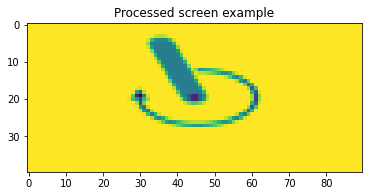

In [26]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()
em.close()

In [27]:
import gym
env = gym.make('Pendulum-v0')
env.reset()
for _ in range(1000):
    env.render()
    #print(len(env.action_space.sample()))
    #print('next')
    #a = [-1.4]
    env.step(env.action_space.sample()) # take a random action
env.close()

In [28]:
#output is a continuous variable

<class 'numpy.ndarray'>


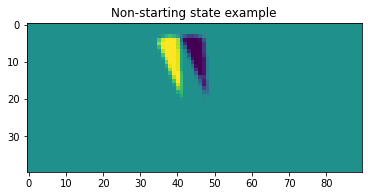

In [30]:
for i in range(5):
    a = [-1.4]
    em.take_action(a)
screen = em.get_state()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non-starting state example')
plt.show()
em.close()

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])


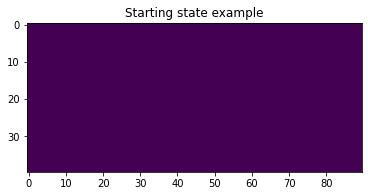

In [30]:
screen = em.get_state()
print(screen)
plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()
em.close()

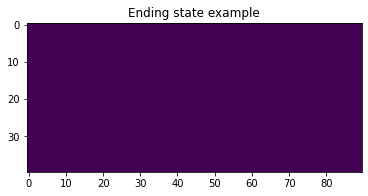

In [31]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

In [28]:
em.close()

In [7]:
class Agent():
    def __init__(self, strategy, device):
        self.current_step = 0
        self.strategy = strategy
        self.device = device

    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            #print('random')
            action = random.randrange(-2,2)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            #print('network')
            with torch.no_grad():
                tensors = policy_net(state).to(self.device) # exploit
                #tensors = tensors.mean().to(self.device)
                return torch.tensor([tensors]).to(self.device)

In [8]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        #what this basically does is given a state and action
        #the probabilities for selected action are grapped from policy net
        #print('squeezing')
        states = states.squeeze()
        return policy_net(states)
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        print('fsl shape: ',final_state_locations.shape)
        non_final_state_locations = (final_state_locations == False)
        print('n-fsl shape: ',non_final_state_locations.shape)
        non_final_states = next_states[non_final_state_locations]
        print('nfsts: ',non_final_states.shape)
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        
        print('target net size: ',non_final_states.shape)
        values[non_final_state_locations] = target_net(non_final_states).detach()
        return values

In [ ]:
batch_size = 100
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 100 # run for more episodes for better results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = EnvManager(device,'Pendulum-v0')
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy,device)
memory = ReplayMemory(memory_size)
output_num = 1
policy_net = LSTM_(em.get_screen_width(),em.get_screen_height(), output_num,batch_size).to(device)
target_net = LSTM_(em.get_screen_width(),em.get_screen_height(), output_num,batch_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            print('states: ', states.shape)
            print('actions: ', actions.shape)
            print('CQV: ',current_q_values.shape)
            next_q_values   = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            current_q_values= current_q_values.to(torch.float32)
            target_q_values = target_q_values.to(torch.float32)
            print('calculating loss....')
            loss = F.mse_loss(current_q_values.unsqueeze(1), target_q_values.unsqueeze(1))
            print('zero grd....')
            optimizer.zero_grad()
            print('bckwrd....')
            loss.backward()
            print('step....')
            optimizer.step()
            
        if em.done:
            print('done')
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break

    if episode % target_update == 0:
        print('updating target...')
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()

outputs:  torch.Size([])  Expected: [1]
batched outputs:  torch.Size([100])  Expected: [256, 1]
states:  torch.Size([100, 1, 40, 90])
actions:  torch.Size([100])
CQV:  torch.Size([100])
fsl shape:  torch.Size([100])
n-fsl shape:  torch.Size([100])
nfsts:  torch.Size([100, 1, 40, 90])
target net size:  torch.Size([100, 1, 40, 90])
batched outputs:  torch.Size([100])  Expected: [256, 1]
calculating loss....
zero grd....
bckwrd....
step....
batched outputs:  torch.Size([100])  Expected: [256, 1]
states:  torch.Size([100, 1, 40, 90])
actions:  torch.Size([100])
CQV:  torch.Size([100])
fsl shape:  torch.Size([100])
n-fsl shape:  torch.Size([100])
nfsts:  torch.Size([100, 1, 40, 90])
target net size:  torch.Size([100, 1, 40, 90])
batched outputs:  torch.Size([100])  Expected: [256, 1]
calculating loss....
zero grd....
bckwrd....
step....
batched outputs:  torch.Size([100])  Expected: [256, 1]
states:  torch.Size([100, 1, 40, 90])
actions:  torch.Size([100])
CQV:  torch.Size([100])
fsl shape:

In [ ]:
em.close()

In [39]:
Experience

__main__.Experience